#Facial Recognition and Verification(with custom facenet_keras_weights)

In this practical, we will learn how to use existing libraries to implement our own Facial Recognition and Facial Verification systems.

This notebook runs only in Colab.

Running this locally in Windows / MacOS is not supported.




## Section 1 - Installing Necessary Libraries

Run the following cell below to install the latest MTCNN library.

The MTCNN library is a Python library that uses the Multi-Task Cascading Convolutional Neural Networks used to detect faces in an image. The Keras implementation can be found here with pre-trained weights can be found here: https://github.com/ipazc/mtcnn

In [1]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.1 MB/s eta 0:00:00


## Section 2 - Mount Google Drive

Run the following cell as is to mount Google Drive.

Upload all necessary content for this practical into your Google Drive's Data/D7 folder.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

folder = '/content/drive/My Drive/Data/ITI108/D5/'
train_folder = folder + '/data'


Mounted at /content/drive


## Section 3 - Declare a List of Functions

Run the following cell to define a list of functions that we will be using later on.

Click on the "SHOW CODE" to see the codes that we have written.


In [9]:
#@title
import numpy as np
import cv2
from IPython.display import Image, display
from google.colab.patches import cv2_imshow
from mtcnn import MTCNN

import tensorflow
from tensorflow import keras

from tensorflow.keras.layers import Conv2D, Activation, Input, Add, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate, Lambda, add, GlobalAveragePooling2D, Convolution2D, LocallyConnected2D, ZeroPadding2D, concatenate, AveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K


# Loads an image from a file using OpenCV.
# NOTE: OpenCV loads an image in BGR format by default,
#       so we must convert it back to the RGB format.
#
def load_image(filename):
    img = cv2.imread(filename)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def normalize(img):
    mean, std = img.mean(), img.std()
    return (img - mean) / std

# Draw a bounding box over the image with a
# text.
#
def draw_box(img, x1, y1, x2, y2, text):
    img = cv2.rectangle(img,(x1,y1),(x2,y2),(255,255,0),2)

    if text != "":
        img = cv2.rectangle(img,(x1,y1),(x2,y1 + 12),(255,255,0),-1)
        img = cv2.putText(img, text, (x1, y1 + 10), cv2.FONT_HERSHEY_PLAIN, 0.7, (0,0,0), 1, cv2.LINE_AA)

    return img


# Crops out parts of an image based on a list of bounding
# boxes. The cropped faces are also resized to 160x160 in
# preparation for passing it to FaceNet to compute the
# face embeddings.
#
def crop_faces_to_160x160(img, bounding_boxes):
    cropped_faces = []

    for (x,y,w,h) in bounding_boxes:
        cropped_face = img[y:y+h, x:x+w]
        normalize(cropped_face)
        cropped_face = cv2.resize(cropped_face, (160, 160), interpolation=cv2.INTER_CUBIC)
        cropped_faces.append(cropped_face)

    return np.array(cropped_faces)


# Shows an image in Colab
#
def show_image(img):
    cv2_imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))



from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename


def launch_camera(prompt, filename):

    print (prompt)
    try:
      filename1 = take_photo(filename)
      print('Saved to ' + filename1)

      # Show the image which was just taken.
      #show_image(filename1)

    except Exception as err:
      # Errors will be thrown if the user does not have a webcam or if they do not
      # grant the page permission to access it.
      print(str(err))


Next, write the necessary codes to load the MTCNN library and use it to detect faces in an RGB image of any size.

To load the MTCNN library, use the following code:

```
face_detector_mtcnn = MTCNN()
```

In the detect_faces_with_cnn function, use the following codes to call MTCNN to detect faces and draw bounding boxes in an image:

```
bounding_boxes = []
detected_faces = face_detector_mtcnn.detect_faces(img)
for detected_face in detected_faces:
    bounding_boxes.append(detected_face["box"])

return bounding_boxes
```


In [5]:
# TODO:
# Loads the MTCNN pre-trained model for facial detection
#...#
face_detector_mtcnn = MTCNN()


# Use MTCNN to detect face bounding boxes. The bounding boxes
# returned from this function will be in the following format:
# [
#    (x, y, w, h),
#    (x, y, w, h),
#    ...
# ]
#
def detect_faces_with_mtcnn(img):

    # TODO:
    # Call the face_detector_mtcnn's detect_faces_with_mtcnn function.
    # Then, extract only the bounding boxes and return the results
    # to the caller as described in the format above.
    #
    #...#
    bounding_boxes = []
    detected_faces = face_detector_mtcnn.detect_faces(img)
    for detected_face in detected_faces:
        bounding_boxes.append(detected_face["box"])

    return bounding_boxes

The FaceNet implementation in Keras with the pre-trained weights on the Microsoft 1 Million Celeb dataset can be found at: https://github.com/nyoki-mtl/keras-facenet. The same model has been provided to you in the data that you downloaded from Polymall.

In the next cell,

1. Load up a pre-trained FaceNet model:

    ```
    from tensorflow.keras.models import load_model
    face_encoder = InceptionResNetV2()
    face_embedding_facenet = face_encoder.load_weights(folder + '/models/facenet_keras_weights.h5')
    ```

2. Call the FaceNet model to retrieve our face embeddings:

    ```
    cropped_faces = (cropped_faces.astype("float32") - 128) / 128
    return face_embedding_facenet.predict(cropped_faces)
    ```

    *NOTE: that before you can pass in the RGB image, the RGB values in the image has to be readjusted from 0 - 255 to -1.0 to 1.0. That is the purpose of the formula (x - 128) / 128.*


In [6]:
def scaling(x, scale):
	return x * scale

def InceptionResNetV2():

	inputs = Input(shape=(160, 160, 3))
	x = Conv2D(32, 3, strides=2, padding='valid', use_bias=False, name= 'Conv2d_1a_3x3') (inputs)
	x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Conv2d_1a_3x3_BatchNorm')(x)
	x = Activation('relu', name='Conv2d_1a_3x3_Activation')(x)
	x = Conv2D(32, 3, strides=1, padding='valid', use_bias=False, name= 'Conv2d_2a_3x3') (x)
	x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Conv2d_2a_3x3_BatchNorm')(x)
	x = Activation('relu', name='Conv2d_2a_3x3_Activation')(x)
	x = Conv2D(64, 3, strides=1, padding='same', use_bias=False, name= 'Conv2d_2b_3x3') (x)
	x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Conv2d_2b_3x3_BatchNorm')(x)
	x = Activation('relu', name='Conv2d_2b_3x3_Activation')(x)
	x = MaxPooling2D(3, strides=2, name='MaxPool_3a_3x3')(x)
	x = Conv2D(80, 1, strides=1, padding='valid', use_bias=False, name= 'Conv2d_3b_1x1') (x)
	x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Conv2d_3b_1x1_BatchNorm')(x)
	x = Activation('relu', name='Conv2d_3b_1x1_Activation')(x)
	x = Conv2D(192, 3, strides=1, padding='valid', use_bias=False, name= 'Conv2d_4a_3x3') (x)
	x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Conv2d_4a_3x3_BatchNorm')(x)
	x = Activation('relu', name='Conv2d_4a_3x3_Activation')(x)
	x = Conv2D(256, 3, strides=2, padding='valid', use_bias=False, name= 'Conv2d_4b_3x3') (x)
	x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Conv2d_4b_3x3_BatchNorm')(x)
	x = Activation('relu', name='Conv2d_4b_3x3_Activation')(x)

	# 5x Block35 (Inception-ResNet-A block):
	branch_0 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_1_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_1_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block35_1_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_1_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_1_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_1_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_1_Branch_1_Conv2d_0b_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_1_Branch_1_Conv2d_0b_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_1_Branch_1_Conv2d_0b_3x3_Activation')(branch_1)
	branch_2 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_1_Branch_2_Conv2d_0a_1x1') (x)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_1_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_1_Branch_2_Conv2d_0a_1x1_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_1_Branch_2_Conv2d_0b_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_1_Branch_2_Conv2d_0b_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_1_Branch_2_Conv2d_0b_3x3_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_1_Branch_2_Conv2d_0c_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_1_Branch_2_Conv2d_0c_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_1_Branch_2_Conv2d_0c_3x3_Activation')(branch_2)
	branches = [branch_0, branch_1, branch_2]
	mixed = Concatenate(axis=3, name='Block35_1_Concatenate')(branches)
	up = Conv2D(256, 1, strides=1, padding='same', use_bias=True, name= 'Block35_1_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.17})(up)
	x = add([x, up])
	x = Activation('relu', name='Block35_1_Activation')(x)

	branch_0 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_2_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_2_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block35_2_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_2_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_2_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_2_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_2_Branch_1_Conv2d_0b_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_2_Branch_1_Conv2d_0b_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_2_Branch_1_Conv2d_0b_3x3_Activation')(branch_1)
	branch_2 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_2_Branch_2_Conv2d_0a_1x1') (x)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_2_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_2_Branch_2_Conv2d_0a_1x1_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_2_Branch_2_Conv2d_0b_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_2_Branch_2_Conv2d_0b_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_2_Branch_2_Conv2d_0b_3x3_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_2_Branch_2_Conv2d_0c_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_2_Branch_2_Conv2d_0c_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_2_Branch_2_Conv2d_0c_3x3_Activation')(branch_2)
	branches = [branch_0, branch_1, branch_2]
	mixed = Concatenate(axis=3, name='Block35_2_Concatenate')(branches)
	up = Conv2D(256, 1, strides=1, padding='same', use_bias=True, name= 'Block35_2_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.17})(up)
	x = add([x, up])
	x = Activation('relu', name='Block35_2_Activation')(x)

	branch_0 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_3_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_3_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block35_3_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_3_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_3_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_3_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_3_Branch_1_Conv2d_0b_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_3_Branch_1_Conv2d_0b_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_3_Branch_1_Conv2d_0b_3x3_Activation')(branch_1)
	branch_2 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_3_Branch_2_Conv2d_0a_1x1') (x)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_3_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_3_Branch_2_Conv2d_0a_1x1_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_3_Branch_2_Conv2d_0b_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_3_Branch_2_Conv2d_0b_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_3_Branch_2_Conv2d_0b_3x3_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_3_Branch_2_Conv2d_0c_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_3_Branch_2_Conv2d_0c_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_3_Branch_2_Conv2d_0c_3x3_Activation')(branch_2)
	branches = [branch_0, branch_1, branch_2]
	mixed = Concatenate(axis=3, name='Block35_3_Concatenate')(branches)
	up = Conv2D(256, 1, strides=1, padding='same', use_bias=True, name= 'Block35_3_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.17})(up)
	x = add([x, up])
	x = Activation('relu', name='Block35_3_Activation')(x)

	branch_0 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_4_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_4_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block35_4_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_4_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_4_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_4_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_4_Branch_1_Conv2d_0b_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_4_Branch_1_Conv2d_0b_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_4_Branch_1_Conv2d_0b_3x3_Activation')(branch_1)
	branch_2 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_4_Branch_2_Conv2d_0a_1x1') (x)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_4_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_4_Branch_2_Conv2d_0a_1x1_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_4_Branch_2_Conv2d_0b_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_4_Branch_2_Conv2d_0b_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_4_Branch_2_Conv2d_0b_3x3_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_4_Branch_2_Conv2d_0c_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_4_Branch_2_Conv2d_0c_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_4_Branch_2_Conv2d_0c_3x3_Activation')(branch_2)
	branches = [branch_0, branch_1, branch_2]
	mixed = Concatenate(axis=3, name='Block35_4_Concatenate')(branches)
	up = Conv2D(256, 1, strides=1, padding='same', use_bias=True, name= 'Block35_4_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.17})(up)
	x = add([x, up])
	x = Activation('relu', name='Block35_4_Activation')(x)

	branch_0 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_5_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_5_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block35_5_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_5_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_5_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_5_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_5_Branch_1_Conv2d_0b_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_5_Branch_1_Conv2d_0b_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_5_Branch_1_Conv2d_0b_3x3_Activation')(branch_1)
	branch_2 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_5_Branch_2_Conv2d_0a_1x1') (x)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_5_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_5_Branch_2_Conv2d_0a_1x1_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_5_Branch_2_Conv2d_0b_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_5_Branch_2_Conv2d_0b_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_5_Branch_2_Conv2d_0b_3x3_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_5_Branch_2_Conv2d_0c_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_5_Branch_2_Conv2d_0c_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_5_Branch_2_Conv2d_0c_3x3_Activation')(branch_2)
	branches = [branch_0, branch_1, branch_2]
	mixed = Concatenate(axis=3, name='Block35_5_Concatenate')(branches)
	up = Conv2D(256, 1, strides=1, padding='same', use_bias=True, name= 'Block35_5_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.17})(up)
	x = add([x, up])
	x = Activation('relu', name='Block35_5_Activation')(x)

	# Mixed 6a (Reduction-A block):
	branch_0 = Conv2D(384, 3, strides=2, padding='valid', use_bias=False, name= 'Mixed_6a_Branch_0_Conv2d_1a_3x3') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_6a_Branch_0_Conv2d_1a_3x3_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Mixed_6a_Branch_0_Conv2d_1a_3x3_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Mixed_6a_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_6a_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Mixed_6a_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, 3, strides=1, padding='same', use_bias=False, name= 'Mixed_6a_Branch_1_Conv2d_0b_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_6a_Branch_1_Conv2d_0b_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Mixed_6a_Branch_1_Conv2d_0b_3x3_Activation')(branch_1)
	branch_1 = Conv2D(256, 3, strides=2, padding='valid', use_bias=False, name= 'Mixed_6a_Branch_1_Conv2d_1a_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_6a_Branch_1_Conv2d_1a_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Mixed_6a_Branch_1_Conv2d_1a_3x3_Activation')(branch_1)
	branch_pool = MaxPooling2D(3, strides=2, padding='valid', name='Mixed_6a_Branch_2_MaxPool_1a_3x3')(x)
	branches = [branch_0, branch_1, branch_pool]
	x = Concatenate(axis=3, name='Mixed_6a')(branches)

	# 10x Block17 (Inception-ResNet-B block):
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_1_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_1_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_1_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_1_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_1_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_1_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_1_Branch_1_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_1_Branch_1_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_1_Branch_1_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_1_Branch_1_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_1_Branch_1_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_1_Branch_1_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_1_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_1_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_1_Activation')(x)

	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_2_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_2_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_2_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_2_Branch_2_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_2_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_2_Branch_2_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_2_Branch_2_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_2_Branch_2_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_2_Branch_2_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_2_Branch_2_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_2_Branch_2_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_2_Branch_2_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_2_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_2_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_2_Activation')(x)

	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_3_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_3_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_3_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_3_Branch_3_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_3_Branch_3_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_3_Branch_3_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_3_Branch_3_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_3_Branch_3_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_3_Branch_3_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_3_Branch_3_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_3_Branch_3_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_3_Branch_3_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_3_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_3_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_3_Activation')(x)

	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_4_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_4_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_4_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_4_Branch_4_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_4_Branch_4_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_4_Branch_4_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_4_Branch_4_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_4_Branch_4_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_4_Branch_4_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_4_Branch_4_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_4_Branch_4_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_4_Branch_4_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_4_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_4_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_4_Activation')(x)

	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_5_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_5_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_5_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_5_Branch_5_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_5_Branch_5_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_5_Branch_5_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_5_Branch_5_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_5_Branch_5_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_5_Branch_5_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_5_Branch_5_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_5_Branch_5_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_5_Branch_5_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_5_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_5_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_5_Activation')(x)

	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_6_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_6_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_6_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_6_Branch_6_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_6_Branch_6_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_6_Branch_6_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_6_Branch_6_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_6_Branch_6_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_6_Branch_6_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_6_Branch_6_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_6_Branch_6_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_6_Branch_6_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_6_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_6_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_6_Activation')(x)

	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_7_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_7_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_7_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_7_Branch_7_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_7_Branch_7_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_7_Branch_7_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_7_Branch_7_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_7_Branch_7_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_7_Branch_7_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_7_Branch_7_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_7_Branch_7_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_7_Branch_7_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_7_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_7_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_7_Activation')(x)

	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_8_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_8_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_8_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_8_Branch_8_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_8_Branch_8_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_8_Branch_8_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_8_Branch_8_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_8_Branch_8_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_8_Branch_8_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_8_Branch_8_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_8_Branch_8_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_8_Branch_8_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_8_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_8_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_8_Activation')(x)

	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_9_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_9_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_9_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_9_Branch_9_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_9_Branch_9_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_9_Branch_9_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_9_Branch_9_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_9_Branch_9_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_9_Branch_9_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_9_Branch_9_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_9_Branch_9_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_9_Branch_9_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_9_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_9_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_9_Activation')(x)

	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_10_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_10_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_10_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_10_Branch_10_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_10_Branch_10_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_10_Branch_10_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_10_Branch_10_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_10_Branch_10_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_10_Branch_10_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_10_Branch_10_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_10_Branch_10_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_10_Branch_10_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_10_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_10_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_10_Activation')(x)

	# Mixed 7a (Reduction-B block): 8 x 8 x 2080
	branch_0 = Conv2D(256, 1, strides=1, padding='same', use_bias=False, name= 'Mixed_7a_Branch_0_Conv2d_0a_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_0_Conv2d_0a_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Mixed_7a_Branch_0_Conv2d_0a_1x1_Activation')(branch_0)
	branch_0 = Conv2D(384, 3, strides=2, padding='valid', use_bias=False, name= 'Mixed_7a_Branch_0_Conv2d_1a_3x3') (branch_0)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_0_Conv2d_1a_3x3_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Mixed_7a_Branch_0_Conv2d_1a_3x3_Activation')(branch_0)
	branch_1 = Conv2D(256, 1, strides=1, padding='same', use_bias=False, name= 'Mixed_7a_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Mixed_7a_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(256, 3, strides=2, padding='valid', use_bias=False, name= 'Mixed_7a_Branch_1_Conv2d_1a_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_1_Conv2d_1a_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Mixed_7a_Branch_1_Conv2d_1a_3x3_Activation')(branch_1)
	branch_2 = Conv2D(256, 1, strides=1, padding='same', use_bias=False, name= 'Mixed_7a_Branch_2_Conv2d_0a_1x1') (x)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Mixed_7a_Branch_2_Conv2d_0a_1x1_Activation')(branch_2)
	branch_2 = Conv2D(256, 3, strides=1, padding='same', use_bias=False, name= 'Mixed_7a_Branch_2_Conv2d_0b_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_2_Conv2d_0b_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Mixed_7a_Branch_2_Conv2d_0b_3x3_Activation')(branch_2)
	branch_2 = Conv2D(256, 3, strides=2, padding='valid', use_bias=False, name= 'Mixed_7a_Branch_2_Conv2d_1a_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_2_Conv2d_1a_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Mixed_7a_Branch_2_Conv2d_1a_3x3_Activation')(branch_2)
	branch_pool = MaxPooling2D(3, strides=2, padding='valid', name='Mixed_7a_Branch_3_MaxPool_1a_3x3')(x)
	branches = [branch_0, branch_1, branch_2, branch_pool]
	x = Concatenate(axis=3, name='Mixed_7a')(branches)

	# 5x Block8 (Inception-ResNet-C block):

	branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_1_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_1_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block8_1_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_1_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_1_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_1_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False, name= 'Block8_1_Branch_1_Conv2d_0b_1x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_1_Branch_1_Conv2d_0b_1x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_1_Branch_1_Conv2d_0b_1x3_Activation')(branch_1)
	branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False, name= 'Block8_1_Branch_1_Conv2d_0c_3x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_1_Branch_1_Conv2d_0c_3x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_1_Branch_1_Conv2d_0c_3x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block8_1_Concatenate')(branches)
	up = Conv2D(1792, 1, strides=1, padding='same', use_bias=True, name= 'Block8_1_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.2})(up)
	x = add([x, up])
	x = Activation('relu', name='Block8_1_Activation')(x)

	branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_2_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_2_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block8_2_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_2_Branch_2_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_2_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_2_Branch_2_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False, name= 'Block8_2_Branch_2_Conv2d_0b_1x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_2_Branch_2_Conv2d_0b_1x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_2_Branch_2_Conv2d_0b_1x3_Activation')(branch_1)
	branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False, name= 'Block8_2_Branch_2_Conv2d_0c_3x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_2_Branch_2_Conv2d_0c_3x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_2_Branch_2_Conv2d_0c_3x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block8_2_Concatenate')(branches)
	up = Conv2D(1792, 1, strides=1, padding='same', use_bias=True, name= 'Block8_2_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.2})(up)
	x = add([x, up])
	x = Activation('relu', name='Block8_2_Activation')(x)

	branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_3_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_3_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block8_3_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_3_Branch_3_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_3_Branch_3_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_3_Branch_3_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False, name= 'Block8_3_Branch_3_Conv2d_0b_1x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_3_Branch_3_Conv2d_0b_1x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_3_Branch_3_Conv2d_0b_1x3_Activation')(branch_1)
	branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False, name= 'Block8_3_Branch_3_Conv2d_0c_3x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_3_Branch_3_Conv2d_0c_3x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_3_Branch_3_Conv2d_0c_3x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block8_3_Concatenate')(branches)
	up = Conv2D(1792, 1, strides=1, padding='same', use_bias=True, name= 'Block8_3_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.2})(up)
	x = add([x, up])
	x = Activation('relu', name='Block8_3_Activation')(x)

	branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_4_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_4_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block8_4_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_4_Branch_4_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_4_Branch_4_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_4_Branch_4_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False, name= 'Block8_4_Branch_4_Conv2d_0b_1x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_4_Branch_4_Conv2d_0b_1x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_4_Branch_4_Conv2d_0b_1x3_Activation')(branch_1)
	branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False, name= 'Block8_4_Branch_4_Conv2d_0c_3x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_4_Branch_4_Conv2d_0c_3x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_4_Branch_4_Conv2d_0c_3x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block8_4_Concatenate')(branches)
	up = Conv2D(1792, 1, strides=1, padding='same', use_bias=True, name= 'Block8_4_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.2})(up)
	x = add([x, up])
	x = Activation('relu', name='Block8_4_Activation')(x)

	branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_5_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_5_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block8_5_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_5_Branch_5_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_5_Branch_5_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_5_Branch_5_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False, name= 'Block8_5_Branch_5_Conv2d_0b_1x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_5_Branch_5_Conv2d_0b_1x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_5_Branch_5_Conv2d_0b_1x3_Activation')(branch_1)
	branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False, name= 'Block8_5_Branch_5_Conv2d_0c_3x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_5_Branch_5_Conv2d_0c_3x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_5_Branch_5_Conv2d_0c_3x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block8_5_Concatenate')(branches)
	up = Conv2D(1792, 1, strides=1, padding='same', use_bias=True, name= 'Block8_5_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.2})(up)
	x = add([x, up])
	x = Activation('relu', name='Block8_5_Activation')(x)

	branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_6_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_6_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block8_6_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_6_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_6_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_6_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False, name= 'Block8_6_Branch_1_Conv2d_0b_1x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_6_Branch_1_Conv2d_0b_1x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_6_Branch_1_Conv2d_0b_1x3_Activation')(branch_1)
	branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False, name= 'Block8_6_Branch_1_Conv2d_0c_3x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_6_Branch_1_Conv2d_0c_3x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_6_Branch_1_Conv2d_0c_3x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block8_6_Concatenate')(branches)
	up = Conv2D(1792, 1, strides=1, padding='same', use_bias=True, name= 'Block8_6_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 1})(up)
	x = add([x, up])

	# Classification block
	x = GlobalAveragePooling2D(name='AvgPool')(x)
	x = Dropout(1.0 - 0.8, name='Dropout')(x)
	# Bottleneck
	x = Dense(128, use_bias=False, name='Bottleneck')(x)
	x = BatchNormalization(momentum=0.995, epsilon=0.001, scale=False, name='Bottleneck_BatchNorm')(x)

	# Create model
	model = Model(inputs, x, name='inception_resnet_v1')

	return model


In [10]:
# TODO:
# Load the FaceNet's pre-trained face embedding model.
#...#
from tensorflow.keras.models import load_model
face_embedding_facenet = InceptionResNetV2()
face_embedding_facenet.load_weights(folder + '/models/facenet_keras_weights.h5')


# Gets a list of face embeddings from FaceNet for each cropped face.
#
# The cropped_faces parameter is a numpy array of Nx160x160x3,
# where N is any number of faces cropped from an image.
#
# def get_face_embeddings_with_facenet(cropped_faces):

#     # TODO:
#     # Normalize the cropped image
#     #
#     # Then pass the result into the face_embedding_facenet's predict
#     # model and return the results (Nx128 embeddings) as is.
#     #...#
#     # cropped_faces = (cropped_faces.astype("float32") - 128) / 128
#     cropped_faces = normalize(cropped_faces.astype("float32"))

#     size = (160,160)
#     face = normalize(face)
#     face = cv2.resize(face, size)
#     encode = face_embedding_facenet.predict(np.expand_dims(face, axis=0))[0]
#     return encode



Run the following cell to test and see if the detect_faces_with_mtcc and the get_face_embeddings_with_facenet functions are working as expected.

2/2 [==============================] - 0s 19ms/step


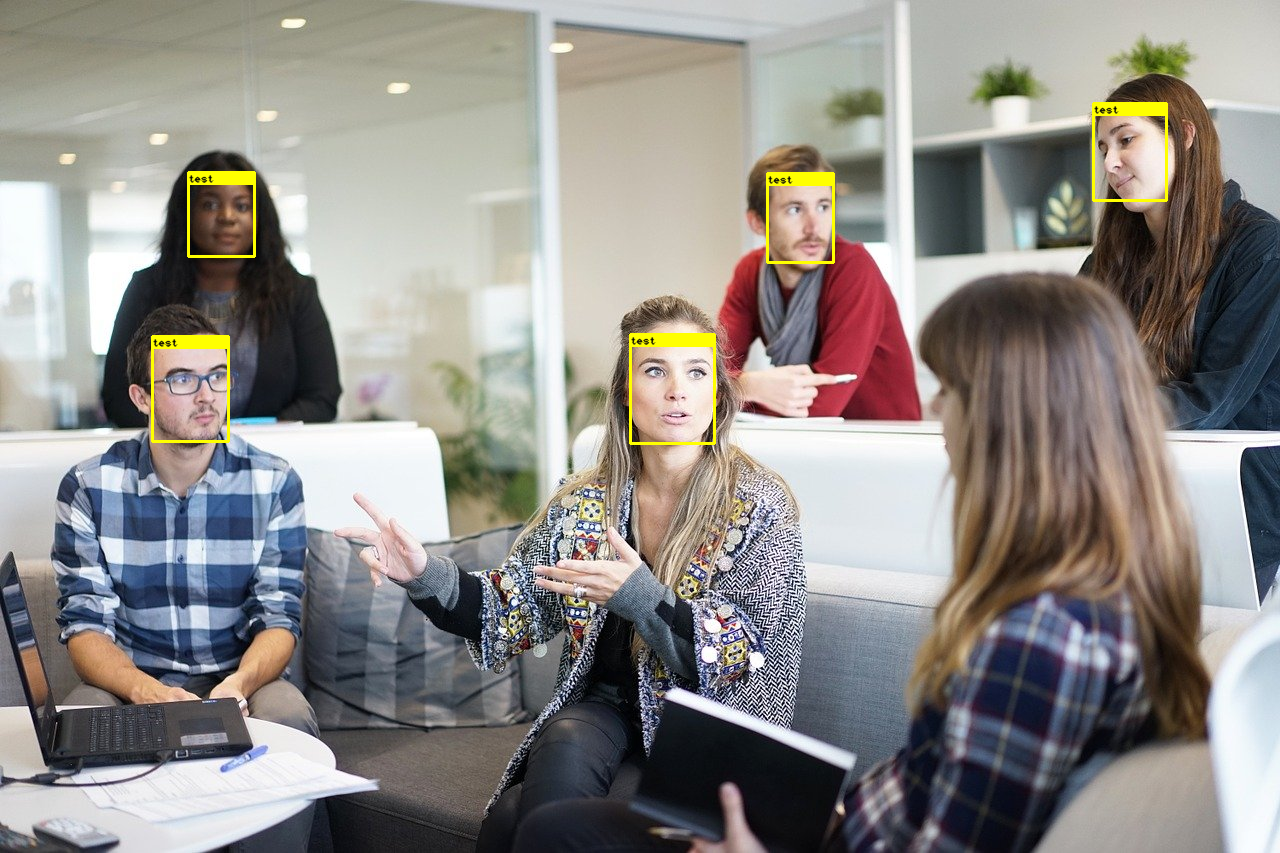

5
1/1 [==============================] - 0s 85ms/step
[[-0.6015636   0.01134536  3.0795112   0.23371205  2.5765681   2.1393242
   3.1460009   0.62244385 -0.11833    -1.6213078   1.6197375  -2.1592367
   0.60059357  1.0127586  -2.8455179  -2.1698306   3.0282438  -3.2471118
  -0.70236856 -2.252662    0.49621084 -3.331675    0.22923765  2.9862988
   1.2846152   4.1056237   1.8104159   0.13282406  0.63429594 -3.4259934
  -0.5686234   2.4903653  -3.3049757   0.33197647  1.1120172   0.7153902
   3.193853    0.14915876  1.1314411   0.82238996  1.2769734  -0.31183988
   2.4561262   0.69016606 -2.807025    2.2153573   3.9000463  -1.3436793
  -0.49194777 -3.1903152   2.7747993   3.3472807   0.48768714 -0.7541937
  -0.22159116  3.254644    0.2217039  -2.7906368   2.8367038   2.8375435
  -1.114362   -0.8568969   1.4806981  -0.8176905  -0.782315    2.6217325
   0.7395405   2.6951566   2.995291    3.2416513   1.1984503   1.1159681
  -1.3033993   2.028805   -1.3871375   3.3990948  -0.02132363  0.7665

In [11]:
# Loads an image for testing
#
img = load_image(folder + '/samples/test.jpg')

# Find all detected faces
#
bounding_boxes = detect_faces_with_mtcnn(img)

# Draws bounding boxes for the faces
#
for (x,y,w,h) in bounding_boxes:
    img = draw_box(img, x, y, x+w, y+h, "test")

# Show the image with the bounding boxes.
#
show_image(img)

# Crop the faces
#
cropped_faces = crop_faces_to_160x160(img, bounding_boxes)

# Print the results of the embeddings for each
# cropped face
embedded_faces=[]
print(len(cropped_faces))
for i in cropped_faces:
  embedded_faces.append(face_embedding_facenet.predict(np.expand_dims(i, axis=0))[0])
  print(face_embedding_facenet.predict(np.expand_dims(i, axis=0)))


## Part 2 - Training

In this section, we will learn how to train our Facial Recognition model.

Note that we are NOT re-training the FaceNet model. We are simply using the outputs of the FaceNet model (recall, FaceNet outputs the 128-dimension vector representing a person's face) and sending those outputs into a Scikit-Learn model for training.

In a way, we are adopting some form of "Transfer Learning". The pre-learned parts are the MTCNN for facial detection and FaceNet for the face embeddings.

Update the following codes below to load the training images from your Google Drive. Please feel free to use photographs of other people than the ones we've provided.

To load the images and convert all of them into face embeddings:

```
# Loop through all sub-folders under the "data" folder.
#
# The sub-folder names will store the name of the person that we are
# trying to learn to recognize.
#
for (root, dirnames, filenames) in os.walk(train_folder):

    for dirname in dirnames:

        # Save the directory name as the person's name
        #
        face_names.append(dirname)
        print (dirname + "/")

        # TODO:
        # List all files within the folder of the person
        #
        for (root2, dirnames2, filenames2) in os.walk(train_folder + "/" + dirname):
            for filename in filenames2:

                # Print the name of the file
                #
                print ("  " + filename)

                # TODO:
                # Load the image
                #...#
                img = load_image(root2 + "/" + filename)

                # TODO:
                # Detect the faces in the image.
                #...#
                face_boxes = detect_faces_with_mtcnn(img)

                # TODO:
                # Crop the faces from the image (we are assuming that
                # there's only 1 face belonging to the person)
                #...#
                cropped_faces = crop_faces_to_160x160(img, face_boxes)

                # TODO:
                # Get the face embeddings and construct the X
                # and Y variables to be used for training.
                #...#
                print("no of face=" ,cropped_faces.shape[0])
                if (cropped_faces.shape[0] > 0):
                    embeddings=[]
                    for i in cropped_faces:
                      embeddings.append(face_embedding_facenet.predict(np.expand_dims(i, axis=0))[0])

                    for e in embeddings:
                        x.append(e)

                        y.append(face_index)

        face_index += 1
```



In [13]:
import os
import sklearn.neighbors
import sklearn.svm

face_names = []
x = []
y = []
face_index = 0

# TODO:
# Loop through all sub-folders under the "data" folder.
#
# The sub-folder names will store the name of the person that we are
# trying to learn to recognize.
#
for (root, dirnames, filenames) in os.walk(train_folder):

    for dirname in dirnames:

        # Save the directory name as the person's name
        #
        face_names.append(dirname)
        print (dirname + "/")

        # TODO:
        # List all files within the folder of the person
        #
        for (root2, dirnames2, filenames2) in os.walk(train_folder + "/" + dirname):
            for filename in filenames2:

                # Print the name of the file
                #
                print ("  " + filename)

                # TODO:
                # Load the image
                #...#
                img = load_image(root2 + "/" + filename)

                # TODO:
                # Detect the faces in the image.
                #...#
                face_boxes = detect_faces_with_mtcnn(img)

                # TODO:
                # Crop the faces from the image (we are assuming that
                # there's only 1 face belonging to the person)
                #...#
                cropped_faces = crop_faces_to_160x160(img, face_boxes)

                # TODO:
                # Get the face embeddings and construct the X
                # and Y variables to be used for training.
                #...#
                print("no of face=" ,cropped_faces.shape[0])
                if (cropped_faces.shape[0] > 0):
                    embeddings=[]
                    for i in cropped_faces:
                      embeddings.append(face_embedding_facenet.predict(np.expand_dims(i, axis=0))[0])

                    for e in embeddings:
                        x.append(e)

                        y.append(face_index)

        face_index += 1




tim_cook/
  timcook01.jpg
1/1 [==============================] - 0s 46ms/step
no of face= 1
1/1 [==============================] - 0s 160ms/step
  timcook02.jpg
1/1 [==============================] - 0s 40ms/step
no of face= 1
1/1 [==============================] - 0s 85ms/step
  tim_cook_03.jpg
1/1 [==============================] - 0s 39ms/step
no of face= 1
1/1 [==============================] - 0s 87ms/step
  tim_cook_04.jpg
1/1 [==============================] - 0s 40ms/step
no of face= 1
1/1 [==============================] - 0s 87ms/step
satya_nadella/
  satya01.jpg
1/1 [==============================] - 0s 40ms/step
no of face= 1
1/1 [==============================] - 0s 140ms/step
  satya02.jpg
1/1 [==============================] - 0s 99ms/step
no of face= 1
1/1 [==============================] - 0s 149ms/step
  satya03.jpg
1/1 [==============================] - 0s 42ms/step
no of face= 1
1/1 [==============================] - 0s 84ms/step
  satya04.jpg
1/1 [=================

Then, to create and train an SVM classifier with our face embeddings, use the following code:

```
classifier = sklearn.svm.SVC(probability=True)
classifier.fit(x, y)
```

In [14]:
# TODO:
# Create our classifier and train it
#...#
classifier = sklearn.svm.SVC(probability=True)
classifier.fit(x, y)

print("Training complete")


Training complete


## Part 3 - Performing Recognition

Now that we've trained a simple SVM model to recognize the embeddings of the few people in our dataset, it's time to see if we can recognize them.

In the function below, called recognize_face, you should write code to:

1. Load the image from the filename.

    ```
    img = load_image(filename)
    ```

2. Detect all bounding boxes of faces with MTCNN.

    ```
    face_boxes = detect_faces_with_mtcnn(img)
    ```

3. Crop out all the detected faces from the image to 160x160 pixels.

    ```
    cropped_faces = crop_faces_to_160x160(img, face_boxes)
    if cropped_faces.shape[0] == 0:
        return
    ```

4. Get the embeddings for all detected faces.

    ```
    embeddings = get_face_embeddings_with_facenet(cropped_faces)
    ```

5. Use our classifier to predict the faces and the probabilities assigned to the best recognized face.

    ```
    probabilities = classifier.predict_proba(embeddings)
    ```

6. Draw the bounding boxes for each face with the recognized name on the image.

    ```
    best_face_index = np.argmax(probabilities[i])
    if probabilities[i][best_face_index] >= threshold:
        result.append({ "box": face_boxes[i], "face" : best_face_index, "face_name": face_names[best_face_index], "score": probabilities[i][best_face_index] })
    else:
        result.append({ "box": face_boxes[i], "face" : -1, "face_name": "??", "score": 0.0 })
    ```


In [16]:

def recognize_face(filename, threshold=0.0, show_cropped_face=True):
    # TODO:
    # Load the image from the filename
    #...#
    img = load_image(filename)

    # TODO:
    # Detect the bounding boxes of all faces using MTCNN
    #...#
    face_boxes = detect_faces_with_mtcnn(img)

    # TODO:
    # Crop out all the faces
    #...#
    cropped_faces = crop_faces_to_160x160(img, face_boxes)
    if cropped_faces.shape[0] == 0:
        return

    # TODO:
    # Extract the embeddings of all cropped faces
    #...#
    # embeddings = get_face_embeddings_with_facenet(cropped_faces)
    embeddings=[]
    for i in cropped_faces:
      embeddings.append(face_embedding_facenet.predict(np.expand_dims(i, axis=0))[0])

    # TODO:
    # Compute the probabilities of all face embeddings using the SVM
    # classifier.
    #
    # The output from the SVM classifier will look something like this:
    #
    #           Person 1       Person 2       Person 3
    #      [
    #          [0.4,           0.5,           0.1      ],    # cropped face 1
    #          [0.1,           0.1,           0.8      ],    # cropped face 2
    #          ...
    #      ]
    #...#
    probabilities = classifier.predict_proba(embeddings)

    # Now run through the probability outputs from SVM
    # and construct a set of results to be returned to the caller
    #
    result = []
    for i in range(0, len(cropped_faces)):
        if show_cropped_face:
            show_image(cropped_faces[i])

        # TODO:
        # Write codes to extract the person recognized and the probability
        # and return the results that looks something like the following:
        #
        #   [
        #       { "box" : (x, y, w, h), "face": 2, "face_name": "steve_jobs", "score": 0.9 },
        #       { "box" : (x, y, w, h), "face": 1, "face_name": "tim_cook", "score": 0.8 },
        #       ...
        #   ]
        #...#
        best_face_index = np.argmax(probabilities[i])
        if probabilities[i][best_face_index] >= threshold:
            result.append({ "box": face_boxes[i], "face" : best_face_index, "face_name": face_names[best_face_index], "score": probabilities[i][best_face_index] })
        else:
            result.append({ "box": face_boxes[i], "face" : -1, "face_name": "??", "score": 0.0 })

    return result





In this next cell, update the codes to call the recognize_face function and draw boxes around the faces in the image with the recognized name.

A practical application will use and process this information for other requirements.

For example, if this is photograph from a CCTV, you may want to track that the person was recognized to be standing at a certain location and a specific date/time this image was captured.

In [17]:

for i in range(1, 8):
    print ("--- photo%d.jpg ---" % (i))

    filename = folder + '/samples/photo%d.jpg' % (i)
    img = load_image(filename)
    results = recognize_face(filename)

    for r in results:
        draw_box(img, r["box"][0], r["box"][1], r["box"][0] + r["box"][2], r["box"][1] + r["box"][3], r["face_name"] + " (%4.2f)" % (r["score"]))

    show_image(img)





Output hidden; open in https://colab.research.google.com to view.

## Part 4 - Using FaceNet for Facial Verification



Let's write for the last time, a function to extract embeddings from a photograph, and assuming that there's only 1 person in the photo.

In the following function, called get_embedding_from_photo:

1. Load the image from the filename.

    ```
    img = load_image(filename)
    ```

2. Detect all bounding boxes of faces with MTCNN.

    ```
    face_boxes = detect_faces_with_mtcnn(img)
    ```

3. Crop out all the detected faces from the image to 160x160 pixels.

    ```
    cropped_faces = crop_faces_to_160x160(img, face_boxes)
    if cropped_faces.shape[0] == 0:
        return
    ```

4. Extract the cropped face of only the first detected face:

    ```
    cropped_face = cropped_faces[0:1, :, :, :]
    ```

5. Show the image of the cropped face:

    ```
    show_image(cropped_face[0])
    ```

6. Compute the face embedding and return the result.

    ```
    return get_face_embeddings_with_facenet(cropped_face)
    ```

In [18]:
from numpy import dot
from numpy.linalg import norm

# Extract embedding from a photograph
#
def get_embedding_from_photo(filename):

    # TODO:
    # Load the image.
    #...#
    img = load_image(filename)

    # TODO:
    # Detect faces and extract all bounding boxes
    #...#
    bounding_boxes = detect_faces_with_mtcnn(img)

    # TODO:
    # Crop out the faces from the image
    #...#
    cropped_faces = crop_faces_to_160x160(img, bounding_boxes)

    if cropped_faces.shape[0] == 0:
        return

    # TODO:
    # Take the image of only the first detected face
    #...#
    cropped_face = cropped_faces[0:1, :, :, :]

    # TODO:
    # Show the cropped out face
    #...#
    show_image(cropped_face[0])

    # TODO:
    # Get the face embeddings using FaceNet and return
    # the results.
    #...#
    embedding= face_embedding_facenet.predict(np.expand_dims(cropped_face[0], axis=0))[0]
    return embedding




A similarity function takes two sets of data and computes a value indicating how "close" two separate pieces of data are. We will have to use this later on to find out whether the photographs of two person belong to the same person.

So, let's declare some functions to compute the cosine similarity and the Euclidean distance between 2 face embeddings.

For the compute_cosine_similarity function, use the following code:

```
a = a[0]
b = b[0]
cos_sim = dot(a, b)/(norm(a)*norm(b))
return cos_sim
```

For the compute_euclidean_distance function, use the following code:

```
a = a[0]
b = b[0]
euc_dist = norm(a - b)
return euc_dist
```



In [19]:

# Update the codes for the following function to compute
# the similarity.
#
# The formula is given by:
#
#                    A . B
#     similarity = ---------
#                   |A| |B|
#
def compute_cosine_similarity(a, b):

    # TODO:
    # Update your codes here:
    #...#
    a = a[0]
    b = b[0]
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim


# Update the codes for the following function to compute
# the eucldiean distance between two vectors.
#
# The formula is given by:
#
#     distance = | A - B |
#
def compute_euclidean_distance(a, b):

    # TODO:
    # Update your codes here:
    #...#
    a = a[0]
    b = b[0]
    euc_dist = norm(a - b)
    return euc_dist

Run the following cell to launch the camera in Colab to take a picture.

We want to simulate using the photograph stored in an access card, passport of an identity card. So you can use any of of identification card that contains your photo.

**NOTE: Your photograph is saved into Google Colab. If you are not comfortable with this, please use a photograph of another person that you can display on your mobile phone**

In [20]:
launch_camera("Take a photo of your identification card", "webcam01.jpg")

Take a photo of your identification card


<IPython.core.display.Javascript object>

Saved to webcam01.jpg


Now, launch the camera again, to take another photograph of your live self.

**NOTE: Your photograph is saved into Google Colab. If you are not comfortable with this, please use a photograph of another person that you can display on your mobile phone**


In [21]:
launch_camera("Take a photo of yourself in the live camera", "webcam02.jpg")

Take a photo of yourself in the live camera


<IPython.core.display.Javascript object>

Saved to webcam02.jpg


Finally run the following cell to call the necessary functions to compute the embedding from both photographs and use the cosine similarity and euclidean distance to compute the similarities.

Additionally, see how we wrote a piece of code to judge if the two photographs belong to the same person if the cosine similarity is a larger than a pre-set threshold of 0.7.


1/1 [==============================] - 0s 45ms/step


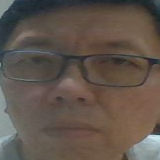

1/1 [==============================] - 0s 32ms/step


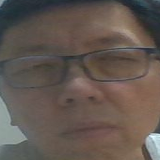

1/1 [==============================] - 0s 83ms/step
Cosine Similarity : 1.000000
Euclidean Distance: 0.268204
Photograph matches the real person (based on cosine similarity)


In [22]:
e1 = get_embedding_from_photo('webcam01.jpg')
e2 = get_embedding_from_photo('webcam02.jpg')

similarity1 = compute_cosine_similarity(e1, e2)
similarity2 = compute_euclidean_distance(e1, e2)

print ("Cosine Similarity : %f" % similarity1)
print ("Euclidean Distance: %f" % similarity2)

if similarity1 >= 0.7:
    print ("Photograph matches the real person (based on cosine similarity)" )
else:
    print ("Photograph does NOT match the real person (based on cosine similarity)")
